In [25]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, InputLayer, TimeDistributed
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

import random

# Define the path to the VCTK corpus
base_path = r".\Dataset"  # Update this path to your dataset location
data_path = base_path # Update based on your folder structure
speaker_info_path = os.path.join(data_path, 'speaker-info.txt')  # Path to speaker-info.txt

# Load speaker info
data = []
with open(speaker_info_path, 'r') as f:  # Use the correct path for speaker-info.txt
    lines = f.readlines()
    # Skip the header
    lines = lines[1:]
    for line in lines:
        line = line.strip()
        if not line:
            continue
        # Split the line into parts
        parts = line.split()
        if len(parts) >= 5:
            ID = parts[0]
            AGE = parts[1]
            GENDER = parts[2]
            ACCENTS = parts[3]
            REGION = ' '.join(parts[4:])
            data.append([ID, AGE, GENDER, ACCENTS, REGION])
        else:
            # Handle lines with missing data
            print(f"Line skipped due to insufficient columns: {line}")
            continue

# Create DataFrame
column_names = ['ID', 'AGE', 'GENDER', 'ACCENTS', 'REGION']
speaker_info = pd.DataFrame(data, columns=column_names)

# Strip whitespace from columns
for col in column_names:
    speaker_info[col] = speaker_info[col].str.strip()

# Convert ID to int
speaker_info['ID'] = speaker_info['ID'].astype(int)

# Print unique GENDER values
print("Unique GENDER values:")
for val in speaker_info['GENDER'].unique():
    print(f"'{val}' (length {len(val)})")

# Now filter male and female speakers
male_speakers = speaker_info[speaker_info['GENDER'] == 'M']['ID'].tolist()
female_speakers = speaker_info[speaker_info['GENDER'] == 'F']['ID'].tolist()

print("Number of male speakers:", len(male_speakers))
print("Number of female speakers:", len(female_speakers))

# Combine male and female speakers
all_speakers = male_speakers + female_speakers

# Convert IDs to string with 'p' prefix and zero-padding
all_speakers = ['p' + str(int(id)).zfill(3) for id in all_speakers]

# Shuffle the list
np.random.seed(42)
np.random.shuffle(all_speakers)

# Total number of speakers
total_speakers = len(all_speakers)
print("Total number of speakers:", total_speakers)

# Calculate the number of speakers for each set
train_size = int(0.8 * total_speakers)
val_size = int(0.1 * total_speakers)
test_size = total_speakers - train_size - val_size  # Ensure all speakers are included

# Split the speakers
train_speakers = all_speakers[:train_size]
val_speakers = all_speakers[train_size:train_size + val_size]
test_speakers = all_speakers[train_size + val_size:]

print(f"Training Speakers ({len(train_speakers)}): {train_speakers}")
print(f"Validation Speakers ({len(val_speakers)}): {val_speakers}")
print(f"Testing Speakers ({len(test_speakers)}): {test_speakers}")


Line skipped due to insufficient columns: 248  23  F    Indian
Line skipped due to insufficient columns: 251  26  M    Indian
Line skipped due to insufficient columns: 329  23  F    American
Line skipped due to insufficient columns: 330  26  F    American
Line skipped due to insufficient columns: 362  29  F    American
Line skipped due to insufficient columns: 376  22  M    Indian
Unique GENDER values:
'F' (length 1)
'M' (length 1)
Number of male speakers: 45
Number of female speakers: 57
Total number of speakers: 102
Training Speakers (81): ['p292', 'p268', 'p262', 'p229', 'p363', 'p347', 'p317', 'p225', 'p254', 'p226', 'p271', 'p298', 'p340', 'p308', 'p295', 'p241', 'p300', 'p304', 'p256', 'p284', 'p351', 'p238', 'p275', 'p269', 'p374', 'p341', 'p260', 'p288', 'p345', 'p252', 'p307', 'p255', 'p361', 'p240', 'p286', 'p265', 'p243', 'p299', 'p266', 'p315', 'p263', 'p318', 'p311', 'p246', 'p364', 'p283', 'p285', 'p272', 'p306', 'p281', 'p297', 'p231', 'p258', 'p279', 'p237', 'p270', 'p3

In [27]:
# Function to load audio files
def load_audio_files(speaker_list, num_sentences_per_speaker, data_path):
    audio_data = []
    for speaker in speaker_list:
        # Update the path to point to the 'wav48' folder inside 'VCTK-Corpus'
        speaker_path = os.path.join(data_path, 'wav48', speaker)
        if not os.path.exists(speaker_path):
            print(f"Speaker folder not found: {speaker_path}")
            continue
        files = os.listdir(speaker_path)
        wav_files = [f for f in files if f.endswith('.wav')]
        wav_files.sort()
        # Select a subset if necessary
        wav_files = wav_files[:num_sentences_per_speaker]
        for wav_file in wav_files:
            file_path = os.path.join(speaker_path, wav_file)
            y, sr = librosa.load(file_path, sr=16000)  # Resample to 16kHz
            audio_data.append(y)
    return audio_data

# Define the number of sentences per speaker
num_sentences_per_speaker = 20  # Adjust as needed

# Define the correct path to 'VCTK-Corpus'
audio_data_path = data_path  # base_path points to the root directory of your project

# Load training data
train_audio = load_audio_files(train_speakers, num_sentences_per_speaker, audio_data_path)
print("Loaded training audio samples:", len(train_audio))

# Load validation data
val_audio = load_audio_files(val_speakers, num_sentences_per_speaker, audio_data_path)
print("Loaded validation audio samples:", len(val_audio))

# Load testing data
test_audio = load_audio_files(test_speakers, num_sentences_per_speaker, audio_data_path)
print("Loaded testing audio samples:", len(test_audio))


Loaded training audio samples: 1620
Loaded validation audio samples: 200
Loaded testing audio samples: 220


In [10]:
# Load Noise Files
import os
import librosa

# Define the path to the noise files
noise_path = os.path.join(base_path, "Noise")  # Base path points to your 'Dataset' directory

# List of noise filenames
noise_filenames = [
    'big-explosion_G_minor.wav', 'car-crash-sound-fx_127bpm.wav', 
    'cartoon-sound-fx-noise-3_103bpm.wav', 'clap-loud_D_major.wav', 
    'gun-bass-old-glitchy-gun.wav', 'gun-shot_100bpm_D_minor.wav', 
    'police-siren_A_minor.wav', 'snare-hit-hard-3.wav', 
    'sound-fx-sub-static-long-tail.wav'
]

# Function to load noise files
def load_noise_files(noise_path, noise_filenames, sr=16000):
    noise_list = []
    for filename in noise_filenames:
        filepath = os.path.join(noise_path, filename)
        if os.path.exists(filepath):
            noise_audio, _ = librosa.load(filepath, sr=sr)  # Resample to 16kHz
            noise_list.append(noise_audio)
        else:
            print(f"Noise file not found: {filepath}")
    return noise_list

# Load the noise files
noise_list = load_noise_files(noise_path, noise_filenames)
print(f"Loaded {len(noise_list)} noise files.")

# Define SNR Levels
snr_levels = [-5, 0, 5]  # Varying SNR levels

# Function to add transient noises and compute masks
def add_transient_noise_to_audio(audio_list, noise_list, snr_levels, sr=16000, n_mels=64):
    features = []
    clean_masks = []
    for audio in audio_list:
        audio_length = len(audio)
        
        # Randomly select a noise
        if len(noise_list) == 0:
            print("No noise files available.")
            continue
        noise_audio = noise_list[np.random.randint(len(noise_list))]
        
        # Ensure the noise fits within the audio length
        if len(noise_audio) >= audio_length:
            # Randomly select a segment of the noise
            start_idx = np.random.randint(0, len(noise_audio) - audio_length + 1)
            noise_segment = noise_audio[start_idx:start_idx + audio_length]
        else:
            # Pad the noise to match the audio length
            noise_segment = np.tile(noise_audio, int(np.ceil(audio_length / len(noise_audio))))[:audio_length]
        
        # Randomly select SNR level
        snr_db = np.random.choice(snr_levels)
        snr_linear = 10 ** (snr_db / 20)
        
        # Scale the noise to achieve the desired SNR
        rms_signal = np.sqrt(np.mean(audio ** 2))
        rms_noise = np.sqrt(np.mean(noise_segment ** 2))
        noise_segment = noise_segment * (rms_signal / (rms_noise * snr_linear))
        
        # Create the noisy audio
        noisy = audio + noise_segment
        
        # Compute mel spectrograms of clean and noisy audio
        S_clean = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
        S_noisy = librosa.feature.melspectrogram(y=noisy, sr=sr, n_mels=n_mels)
        
        # Compute IRM in the time-frequency domain
        eps = 1e-8
        irm = np.minimum(1.0, S_clean / (S_noisy + eps))
        
        # Convert the noisy spectrogram to dB scale
        S_noisy_dB = librosa.power_to_db(S_noisy, ref=np.max)
        
        # Transpose to have time steps first
        features.append(S_noisy_dB.T)
        clean_masks.append(irm.T)
    return features, clean_masks

# Add transient noises to training data
train_features, train_masks = add_transient_noise_to_audio(train_audio, noise_list, snr_levels)
print("Created noisy training audio samples:", len(train_features))

# Add transient noises to validation data
val_features, val_masks = add_transient_noise_to_audio(val_audio, noise_list, snr_levels)
print("Created noisy validation audio samples:", len(val_features))

# Add transient noises to testing data
test_features, test_masks = add_transient_noise_to_audio(test_audio, noise_list, snr_levels)
print("Created noisy testing audio samples:", len(test_features))


Loaded 9 noise files.
Created noisy training audio samples: 1620
Created noisy validation audio samples: 200
Created noisy testing audio samples: 220


In [30]:
# Pad sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Find the maximum timesteps across all datasets
max_timesteps = max(
    max([feature.shape[0] for feature in train_features]),
    max([feature.shape[0] for feature in val_features]),
    max([feature.shape[0] for feature in test_features])
)

# Pad the sequences
train_features_padded = pad_sequences(train_features, maxlen=max_timesteps, dtype='float32', padding='post')
train_masks_padded = pad_sequences(train_masks, maxlen=max_timesteps, dtype='float32', padding='post')

val_features_padded = pad_sequences(val_features, maxlen=max_timesteps, dtype='float32', padding='post')
val_masks_padded = pad_sequences(val_masks, maxlen=max_timesteps, dtype='float32', padding='post')

test_features_padded = pad_sequences(test_features, maxlen=max_timesteps, dtype='float32', padding='post')
test_masks_padded = pad_sequences(test_masks, maxlen=max_timesteps, dtype='float32', padding='post')

# Flatten sequences for MLP input
n_features = train_features_padded.shape[2]
train_features_flat = train_features_padded.reshape(train_features_padded.shape[0], -1)
train_masks_flat = train_masks_padded.reshape(train_masks_padded.shape[0], -1)

val_features_flat = val_features_padded.reshape(val_features_padded.shape[0], -1)
val_masks_flat = val_masks_padded.reshape(val_masks_padded.shape[0], -1)

test_features_flat = test_features_padded.reshape(test_features_padded.shape[0], -1)
test_masks_flat = test_masks_padded.reshape(test_masks_padded.shape[0], -1)

# Build the MLP Model
input_dim = train_features_flat.shape[1]

model = Sequential()
model.add(Input(shape=(input_dim,)))  # Use Input instead of InputLayer
model.add(Dense(128, activation='relu'))  # First hidden layer
model.add(Dense(64, activation='relu'))  # Second hidden layer
model.add(Dense(input_dim, activation='sigmoid'))  # Output layer matches the flattened input shape

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 128)               3858560   
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 30144)             1959360   
                                                                 
Total params: 5,826,176
Trainable params: 5,826,176
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
51/51 [==============================] - 3s 49ms/step - loss: 0.1147 - val_loss: 0.0877
Epoch 2/5
51/51 [==============================] - 2s 45ms/step - loss: 0.0704 - val_loss: 0.0658
Epoch 3/5
51/51 [==============================] - 2s 45ms/step - loss: 0.0568 - val_loss: 0.0639
Epoch 4/5
51/51 [==============================] - 2s 44ms/step - loss: 0.0520 - val_loss: 0.0598
Epoch 5/5
51/51 [==============================] - 2s 45ms/step - loss: 0.0534 - val_loss: 0.0655


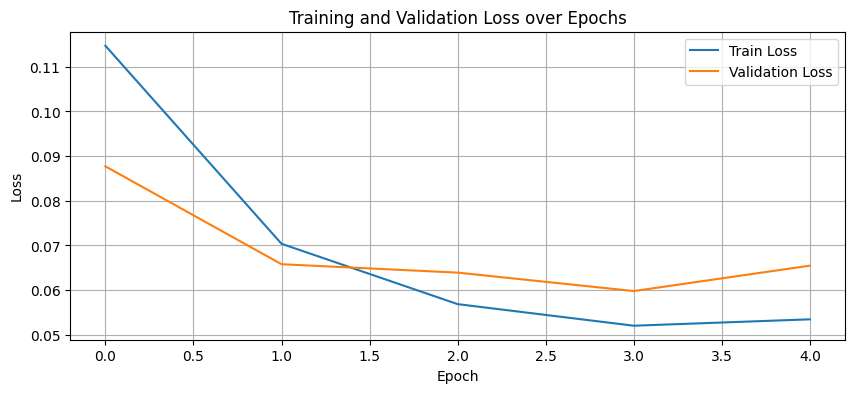

In [31]:
# Train the MLP Model
epochs = 5
batch_size = 32

history = model.fit(
    train_features_flat,  # Flattened input features
    train_masks_flat,     # Flattened output masks
    validation_data=(val_features_flat, val_masks_flat),  # Flattened validation data
    epochs=epochs,
    batch_size=batch_size
)

# Plot Training History
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)  # Add grid for better visualization
plt.show()


7/7 [==============================] - 0s 13ms/step - loss: 0.0586
Test Loss (MSE): 0.058629
1/1 [==============================] - 0s 76ms/step


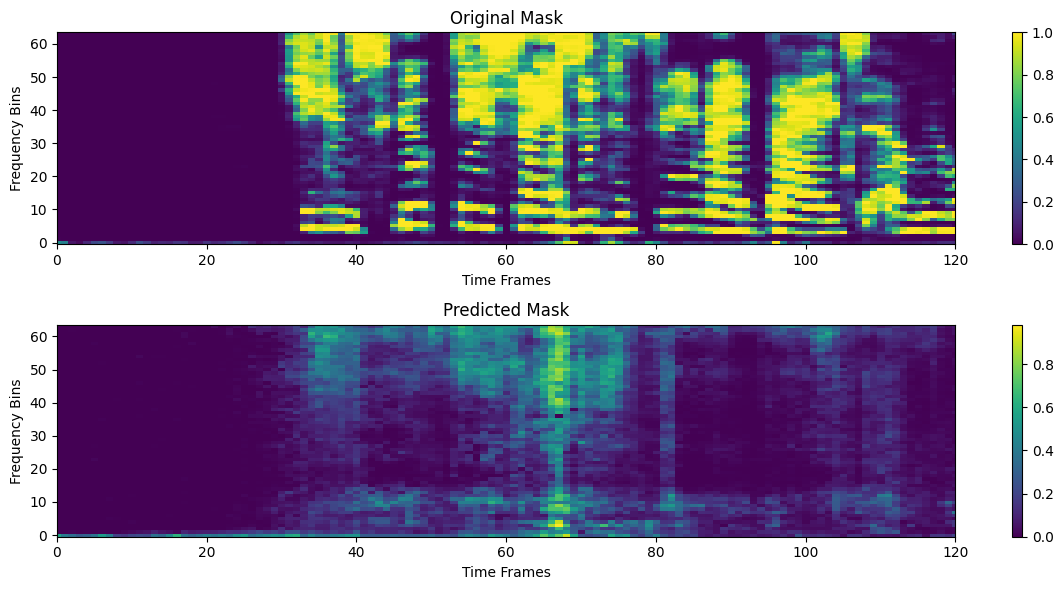

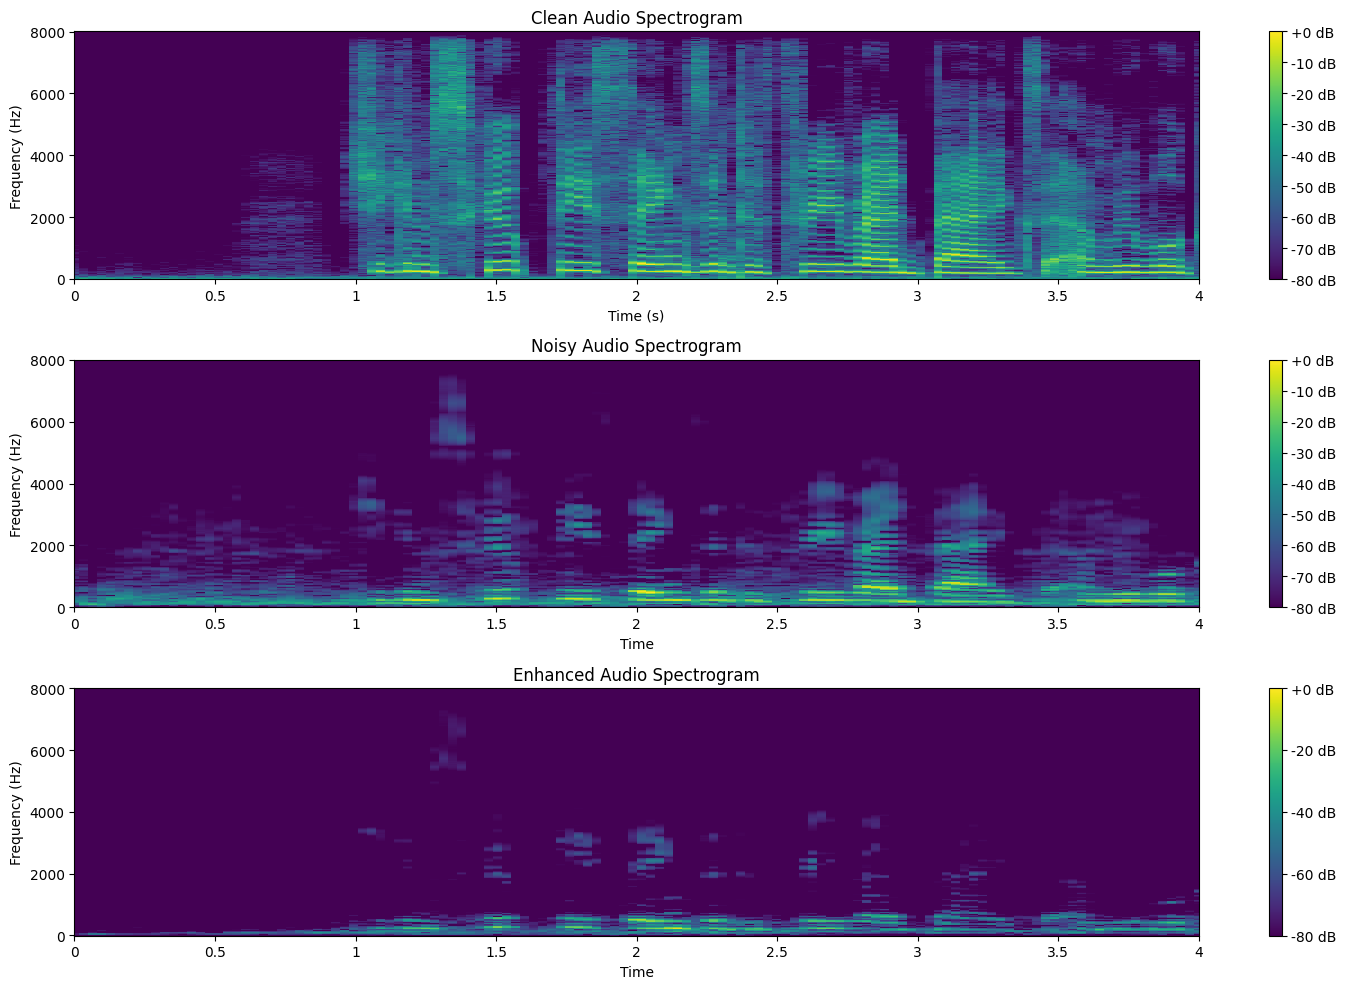

Clean Audio:


Original Noisy Audio:


Enhanced Audio:


In [33]:
# Evaluate the model on the testing set
test_loss = model.evaluate(test_features_flat, test_masks_flat, batch_size=batch_size)  # Use flattened data
print(f"Test Loss (MSE): {test_loss:.6f}")

# Select a test sample
test_sample_index = 3  # Change this index to test different samples
test_sample = test_features_flat[test_sample_index:test_sample_index + 1]
test_mask = test_masks_flat[test_sample_index:test_sample_index + 1]

# Predict the mask
predicted_mask = model.predict(test_sample)

import matplotlib.pyplot as plt

# Visualize the original mask and predicted mask
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.title('Original Mask')
plt.imshow(test_mask.reshape(max_timesteps, n_features).T, aspect='auto', origin='lower', cmap='viridis')  # Reshape for visualization
plt.colorbar()
plt.xlabel('Time Frames')
plt.ylabel('Frequency Bins')
plt.xlim(0, 120)

plt.subplot(2, 1, 2)
plt.title('Predicted Mask')
plt.imshow(predicted_mask.reshape(max_timesteps, n_features).T, aspect='auto', origin='lower', cmap='viridis')  # Reshape for visualization
plt.colorbar()
plt.xlabel('Time Frames')
plt.ylabel('Frequency Bins')
plt.xlim(0, 120)

plt.tight_layout()
plt.show()

# Reconstruct the audio
import librosa

# Get the noisy spectrogram for the test sample
noisy_spectrogram = test_sample.reshape(max_timesteps, n_features).T  # Reshape for compatibility

# Convert back from dB to power
noisy_spectrogram_power = librosa.db_to_power(noisy_spectrogram)

# Apply the predicted mask
enhanced_spectrogram_power = noisy_spectrogram_power * predicted_mask.reshape(max_timesteps, n_features).T

# Reconstruct the enhanced audio
enhanced_audio = librosa.feature.inverse.mel_to_audio(
    enhanced_spectrogram_power,
    sr=16000,
    n_fft=1024,
    hop_length=512,
    power=1.0,
    n_iter=32,
)

# Original noisy audio for comparison
noisy_audio = librosa.feature.inverse.mel_to_audio(
    noisy_spectrogram_power,
    sr=16000,
    n_fft=1024,
    hop_length=512,
    power=1.0,
    n_iter=32,
)

# Clean audio for reference
clean_audio = test_audio[test_sample_index]

# Compute spectrograms
noisy_S = librosa.stft(noisy_audio, n_fft=1024, hop_length=512)
noisy_S_db = librosa.amplitude_to_db(np.abs(noisy_S), ref=np.max)

enhanced_S = librosa.stft(enhanced_audio, n_fft=1024, hop_length=512)
enhanced_S_db = librosa.amplitude_to_db(np.abs(enhanced_S), ref=np.max)

clean_S = librosa.stft(clean_audio, n_fft=1024, hop_length=512)
clean_S_db = librosa.amplitude_to_db(np.abs(clean_S), ref=np.max)

# Plotting spectrograms
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
librosa.display.specshow(clean_S_db, sr=16000, hop_length=512, x_axis='time', y_axis='hz', cmap='viridis')
plt.title('Clean Audio Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.xlim(0, 4)

plt.subplot(3, 1, 2)
librosa.display.specshow(noisy_S_db, sr=16000, hop_length=512, x_axis='time', y_axis='hz', cmap='viridis')
plt.title('Noisy Audio Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.ylabel('Frequency (Hz)')
plt.xlim(0, 4)

plt.subplot(3, 1, 3)
librosa.display.specshow(enhanced_S_db, sr=16000, hop_length=512, x_axis='time', y_axis='hz', cmap='viridis')
plt.title('Enhanced Audio Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.ylabel('Frequency (Hz)')
plt.xlim(0, 4)

plt.tight_layout()
plt.show()

# Play audio
from IPython.display import Audio, display

print("Clean Audio:")
display(Audio(clean_audio, rate=16000))

print("Original Noisy Audio:")
display(Audio(noisy_audio, rate=16000))

print("Enhanced Audio:")
display(Audio(enhanced_audio, rate=16000))


In [34]:
# Compute Performance Metrics

# Function to compute SNR Improvement
def compute_snr(clean_signal, processed_signal):
    # Ensure the signals are the same length
    min_len = min(len(clean_signal), len(processed_signal))
    clean_signal = clean_signal[:min_len]
    processed_signal = processed_signal[:min_len]
    
    # Compute signal power and noise power
    signal_power = np.sum(clean_signal ** 2)
    noise_power = np.sum((clean_signal - processed_signal) ** 2)
    snr = 10 * np.log10(signal_power / (noise_power + 1e-8))
    return snr

# Compute SNR for Noisy and Enhanced Audio
snr_noisy = compute_snr(clean_audio, noisy_audio)  # Using clean and noisy audio
snr_enhanced = compute_snr(clean_audio, enhanced_audio)  # Using clean and enhanced audio

# Calculate SNR Improvement
snr_improvement = snr_enhanced - snr_noisy

print(f"SNR of Noisy Audio: {snr_noisy:.2f} dB")
print(f"SNR of Enhanced Audio: {snr_enhanced:.2f} dB")
print(f"SNR Improvement: {snr_improvement:.2f} dB")

# Compute Mean Squared Error (MSE)
from sklearn.metrics import mean_squared_error

# Ensure the signals are the same length
min_len = min(len(clean_audio), len(enhanced_audio))
clean_signal = clean_audio[:min_len]
enhanced_signal = enhanced_audio[:min_len]

# Compute MSE
mse = mean_squared_error(clean_signal, enhanced_signal)
print(f"Mean Squared Error (MSE): {mse:.6f}")

# Compute PESQ
from pesq import pesq

# Compute PESQ for Wideband
try:
    pesq_score = pesq(16000, clean_signal, enhanced_signal, 'wb')  # Wideband
    print(f"PESQ Score: {pesq_score:.2f}")
except Exception as e:
    print(f"Error computing PESQ: {e}")

# Compute STOI
from pystoi import stoi

# Compute STOI
stoi_score = stoi(clean_signal, enhanced_signal, 16000, extended=False)
print(f"STOI Score: {stoi_score:.2f}")


SNR of Noisy Audio: -0.46 dB
SNR of Enhanced Audio: -0.09 dB
SNR Improvement: 0.37 dB
Mean Squared Error (MSE): 0.005009
PESQ Score: 1.19
STOI Score: 0.57


Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.0478 - val_loss: 0.0576
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0471 - val_loss: 0.0592
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0468 - val_loss: 0.0591
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0468 - val_loss: 0.0568
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0490 - val_loss: 0.0572
Total Training Time: 20.56 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Inference Time for one sample: 0.2895 seconds
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.0469 - val_loss: 0.0552
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0468 - val_loss: 0.0575
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0468 - val_loss: 0.0541
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0428 - val_loss: 0.0589
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0466 - val_loss: 0.0524
Maximum Memory Usage during Training: 42

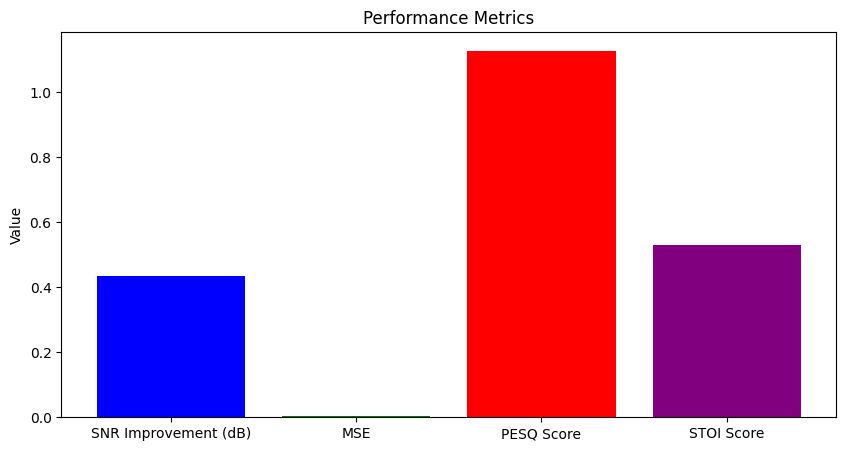

In [21]:
# Compare Performance vs. Computational Cost

# Measure Training Time
import time

# Record the start time
start_time = time.time()

# Train the Model
history = model.fit(
    train_features_flat,  # Flattened training data
    train_masks_flat,     # Flattened training masks
    validation_data=(val_features_flat, val_masks_flat),  # Flattened validation data
    epochs=epochs,
    batch_size=batch_size
)

# Record the end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print(f"Total Training Time: {training_time:.2f} seconds")

# Measure Inference Time
# Record the start time
start_time = time.time()

# Predict the mask
predicted_mask = model.predict(test_features_flat[:1])  # Single sample for inference

# Record the end time
end_time = time.time()

# Calculate inference time
inference_time = end_time - start_time
print(f"Inference Time for one sample: {inference_time:.4f} seconds")

# Measure Memory Usage
from memory_profiler import memory_usage

# Define a function to train the model
def train_model():
    model.fit(
        train_features_flat, train_masks_flat,
        validation_data=(val_features_flat, val_masks_flat),
        epochs=epochs,
        batch_size=batch_size
    )

# Measure memory usage
mem_usage = memory_usage(train_model)
print(f"Maximum Memory Usage during Training: {max(mem_usage) - min(mem_usage):.2f} MiB")

# Create a summary table
metrics = {
    'Training Time (s)': training_time,
    'Inference Time (s)': inference_time,
    'Memory Usage (MiB)': max(mem_usage) - min(mem_usage),
    'Test Loss (MSE)': test_loss,
    'SNR Improvement (dB)': snr_improvement,
    'Mean Squared Error': mse,
    # Commenting PESQ and STOI if their computation is skipped
    'PESQ Score': pesq_score if 'pesq_score' in locals() else 'Skipped',
    'STOI Score': stoi_score if 'stoi_score' in locals() else 'Skipped'
}

# Display the metrics
for key, value in metrics.items():
    print(f"{key}: {value}")

# Visualize Performance Metrics
import matplotlib.pyplot as plt

# Performance metrics
metrics_labels = ['SNR Improvement (dB)', 'MSE', 'PESQ Score', 'STOI Score']
metrics_values = [
    snr_improvement, 
    mse, 
    pesq_score if 'pesq_score' in locals() else 0, 
    stoi_score if 'stoi_score' in locals() else 0
]

plt.figure(figsize=(10, 5))
plt.bar(metrics_labels, metrics_values, color=['blue', 'green', 'red', 'purple'])
plt.title('Performance Metrics')
plt.ylabel('Value')
plt.show()
